# Importando as bibliotecas #

* Opencv é usada para processar as imagens
* MatPlotlib é usada para visualização das imagens
* Numpy define o tipo de imagens em opencv
* os para manipulação do sistema de arquivos

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import math

# Funções para visualização 
As funções a seguir, permitem a axibição das imagens dentro do notbook

In [2]:
def plot_image(img, figsize_in_inches=(10,10)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) # o padrão de opencv é BGR e precisa ser convertido
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(10,10)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) # o padrão de opencv é BGR e precisa ser convertido
    plt.show()

red_color = (0,0,255)

# Variaveis de Log

In [3]:
soma_find_matching_sift = 0  # 2 sift para 1 find_matching
soma_imagens_coladas = 0

# Configurações de Ordem e Salto

In [4]:
# op configura a ordem e o tipo de salto
op = 2 # 1 - ERCS ; 2 - SCS ; 3 - ERCSF ; 4 SCSF
saltoFixo = 0 #Configura tamanho de salto caso op == 3 || 4;

def inicializarPivo(op=1, frames=[]):

    match op:
        case 1 | 3:
            return len(frames) -1
        
        case 2 | 4:
            return 0
        
        #case _:
            #return 0

def inicializarAlvo(op=1, frames=[]):

    match op:
        case 1:
            return math.floor(len(frames) / 2)

        case 2:

            return math.ceil(len(frames) / 2)
        
        case 3:

            return (len(frames) - 1 ) - (saltoFixo + 1)
        
        case 4:

            if( saltoFixo + 1 ) < len(frames):

                return saltoFixo + 1
            
            else:

                return len(frames) - 1
        
        #case _:

            #return saltoFixo


def ajustarAlvo(op=1, frames=[], alvo=0):

    if len(frames) == 0:
        return -1
    
    global saltoFixo

    match op:
        case 1:
            
            return math.floor(len(frames) / 2)  # alvo

        case 2:

            if(len(frames) == 1):
                return 0

            return math.ceil(len(frames) / 2) #alvo

        case 3:
            print("Entrei")
            if (alvo - saltoFixo - 1)  < 0:
                return -1 #Tag para finalizar

            else:
                return alvo - saltoFixo - 1

        case 4:

            if (alvo + saltoFixo + 1 ) <= (len(frames) - 1):
                return alvo + saltoFixo + 1

            else:
                return -1 #Tag para finalizar

        #case _:

            #return math.floor(len(frames) / 2)  # alvo


def reajustarAlvo(op=1, frames=[], alvo=0):

    match op:

        case 1 | 3:

            if alvo + 1 == len(frames):
                return -1
            
            else:
                return alvo + 1  # alvo

        case 2 | 4:

            return alvo - 1  # alvo

        case _:

            return alvo + 1   # alvo

# Leitura das imagens de entrada
O caminho de entrada pode apontar para um vídeo ou para um diretório contendo uma coleção de imagens ordenadas, que representam os frames de um video

In [5]:
def ler_video(path):
    
    # Inicializa a captura de vídeo
    cap = cv.VideoCapture(path)

    # Verifica se a captura de vídeo foi inicializada corretamente
    if not cap.isOpened():
        print("Erro ao abrir o arquivo de vídeo")
        cap.release()
        exit()

    # Lista para armazenar os frames
    frames = []

    # Loop para ler frames do vídeo
    while True:
        # Lê um frame do vídeo
        ret, frame = cap.read()

        # Verifica se o frame foi lido corretamente
        if not ret:
            break
        
        # Adiciona o frame à lista
        frames.append(frame)
        
    return frames

def alinhamento(frame, pontos_inicio):
    
    old_initial_points = pontos_inicio

    min_x = 220
    max_x = 3982
    min_y = 178
    max_y = 2867
    largura = max_x - min_x
    altura = max_y - min_y
    new_final_ponts = np.float32([
                                        [min_x,   min_y],
                                        [max_x,  min_y],
                                        [min_x,   max_y],
                                        [max_x,  max_y]    
    ])
    # estes valores são arbitrários

    # teste de ajuste para planificar a imagem
    new_homography = cv.getPerspectiveTransform(old_initial_points, new_final_ponts)

    print(new_homography)
    
    #novo_frame = cv.warpPerspective(frame, new_homography, (frame.shape[1],frame.shape[0]))
    novo_frame = cv.warpPerspective(frame, new_homography, (largura,altura))

    return novo_frame

def treat_input(path):
    if os.path.isfile(path):
        if path.lower().endswith(('.mp4', '.avi')):
            print("é um video: separar os frames e colocar na pasta frames")

            frames = ler_video(path)
            cont=0
            for frame in frames:
                cv.imwrite(f"frames/img-{cont:04}.jpg", frame)
                print(f"img-{cont:04}")
                cont += 1

    else:
        print("é um conjunto de imagens: ler as imagens em sequencia")

        names = [i for i in os.listdir(path) if i.endswith('.jpg')]
        frames= []
        for name in sorted(names):
            img_path = os.path.join(path,name)
            print( img_path )
            frames.append( cv.imread(img_path))

        # Capturar saida do numero de imagens
        print(f"nIMAGENS:{len(frames)}")

        # frames = [ cv.rotate(frame, cv.ROTATE_90_CLOCKWISE) for frame in frames]

        pontos_inicio = [ 
                     np.float32([   [371,   628],
                                        [4021,  728],
                                        [338,   2556],
                                        [4020,  2562]
                                ]),
                      
                     np.float32([   [16,   774],
                                        [3996,  781],
                                        [36,   2487],
                                        [4002,  2487]
                                ]),
                      
                     np.float32([   [222,   594],
                                        [3962,  874],
                                        [236,   2174],
                                        [3882,  2454]
                                ]),
                      
                     np.float32([   [296,   827],
                                        [3802,  734],
                                        [316,   2654],
                                        [3956,  2627]
                                ]),
                      
                     np.float32([   [149,   747],
                                        [3856,  701],
                                        [162,   2561],
                                        [3969,  2467]
                                ]),
                      
                     np.float32([   [116,   654],
                                        [3829,  647],
                                        [109,   2567],
                                        [3929,  2474]
                                ]),
                      
                     np.float32([   [256,   927],
                                        [3582,  507],
                                        [469,   2754],
                                        [3889,  2281]
                                ]),
                      
                     np.float32([   [89,   594],
                                        [3202,  527],
                                        [109,   2407],
                                        [3289,  2334]
                                ]),
                      
                     np.float32([   [309,   674],
                                        [1762,  654],
                                        [282,   2547],
                                        [1776,  2534]
                                ])
                     
                     ]
        # for i in range(0, len(frames)-1):  # len(frames)):
        # plot_image(frames[i])
        # aqui a função de alinhamento da imagem
        # frames[i] = alinhamento( frames[i], pontos_inicio[i] )
        # plot_image(frames[i])

    return frames
    


frames = treat_input("/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1")
# frames = treat_input("video-02.mp4")
idx_base = inicializarPivo(op, frames)
idx_sec = inicializarAlvo(op, frames) #alvo
print(idx_base, idx_sec)

é um conjunto de imagens: ler as imagens em sequencia
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115035851.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115038926.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115041837.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115045226.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115047605.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115051230.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115053642.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115055909.jpg
/home/atosarruda/Documentos/IC - Erikson/DocAI/stitching/db/1/IMG_20241001_115058291.jpg
nIMAGENS:9
0 5


# Pré-processamento das imagens
* resize para menor com a intenção de minimizar efeitos de ruidos

In [6]:
# Resize with Area algorithm
def resize(img, to_width = 1900):
    # initialize the dimensions of the image to be resized and grab the image size
    (h, w) = img.shape[:2]
    print('Original Dimensions: ',img.shape)
    ratio = to_width / float(w)
    new_dimensions = (int(to_width), int(h * ratio))
    resized = cv.resize(img, new_dimensions, interpolation = cv.INTER_AREA)
    print('Resized Dimensions: ', resized.shape)
    #resized = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    return resized

def sharpening(img):
    # Criar um kernel de nitidez
    kernel = np.array([[0,  -1,  0],
                       [-1,  5, -1],
                       [0,  -1,  0]])

    # Aplicar o filtro de nitidez
    sharpened = cv.filter2D(img, -1, kernel)
    return sharpened


def contraste(img):
    # Converter a imagem de BGR para LAB
    imagem_lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

    # Dividir a imagem LAB em seus três canais (L, A, B)
    l, a, b = cv.split(imagem_lab)
    
    # Criar o objeto CLAHE
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))

    # Aplicar CLAHE apenas no canal L (Luminância)
    l_clahe = clahe.apply(l)

    # Recombinar os canais com o canal L ajustado
    imagem_lab_clahe = cv.merge((l_clahe, a, b))

    # Converter a imagem de volta de LAB para BGR
    imagem_clahe_rgb = cv.cvtColor(imagem_lab_clahe, cv.COLOR_LAB2BGR)
    
    #plot_images( [img, imagem_clahe_rgb] )
    return imagem_clahe_rgb



# frames = [ sharpening(img)  for img in frames ]
# frames = [ contraste(img)   for img in frames ]
frames = [ resize(img)      for img in frames ]

Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)
Original Dimensions:  (3024, 4032, 3)
Resized Dimensions:  (1425, 1900, 3)


# Encontrar características
Encontra características usando SIFT

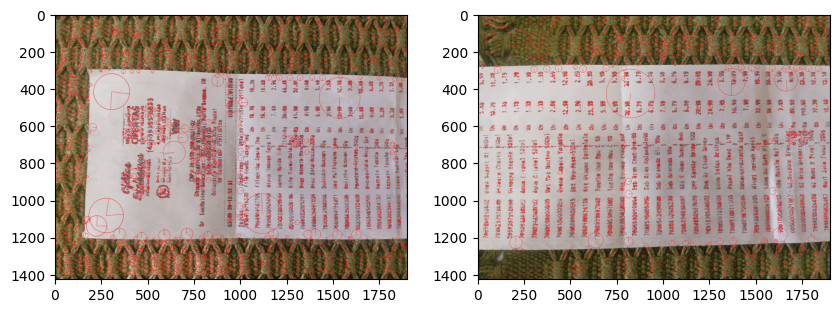

Not enough matches are found - 112/150


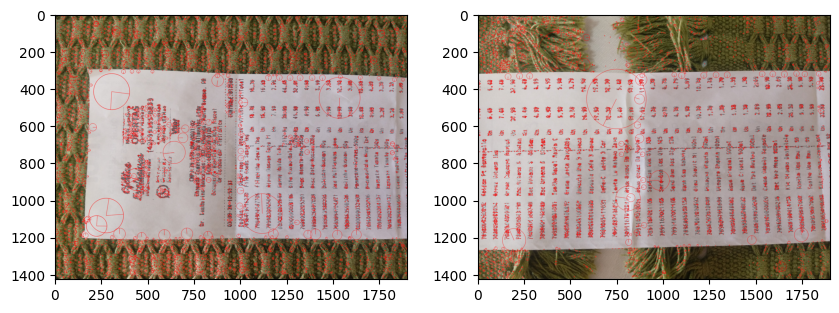

Not enough matches are found - 110/150


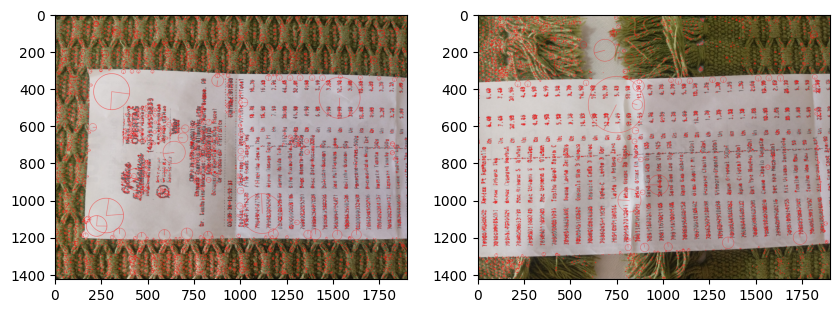

Not enough matches are found - 107/150


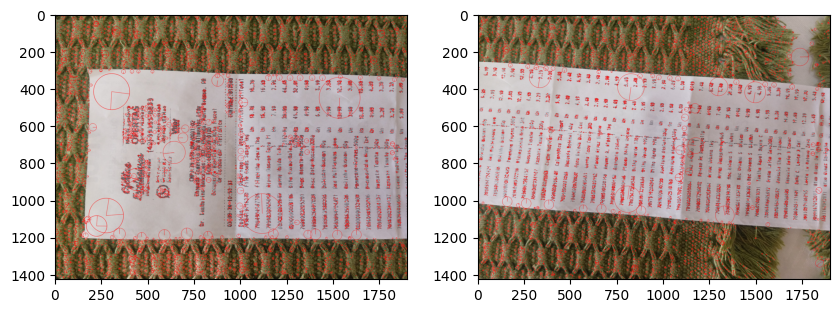

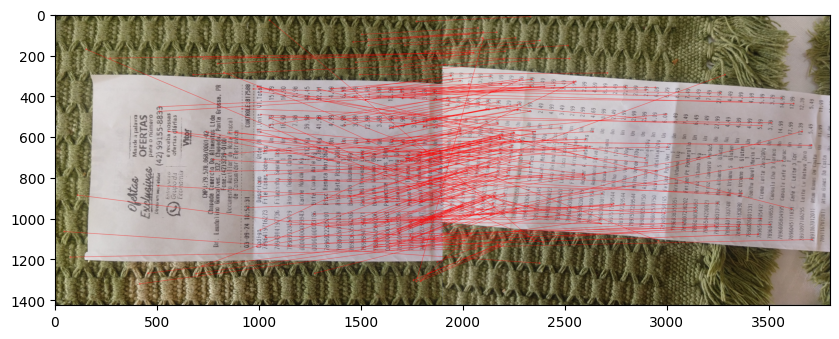

0 2


In [7]:
def find_doc_mask(img):
    gray = img.copy()
    if len(img.shape) == 3:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    threshold = 100
    # TODO
    # verificar uma formam de encontrar o threshold automaticamente
    
    mask = cv.threshold(gray, threshold, 255, cv.THRESH_BINARY)[1]
    return mask

# Gerada por IA

def create_roi_mask(image_shape, side='left', ratio=0.5):
    h, w = image_shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8) # Cria uma imagem preta
    pixel_width = int(w * ratio) # Define a largura da busca baseada na porcentagem

    if side == 'left':
        # Pinta de branco apenas o lado esquerdo
        mask[:, :pixel_width] = 255

    elif side == 'right':
        # Pinta de branco apenas o lado direito
        mask[:, w - pixel_width:] = 255
    return mask

def draw_matches(matches, base_image, sec_image, base_image_kp, sec_image_kp):
    draw_params = dict(matchColor = red_color, singlePointColor = None, flags = 2)
    match = cv.drawMatches(base_image, base_image_kp, sec_image, sec_image_kp, matches, None, **draw_params)
    plot_image(match)

def get_featured_image(img, kp):
    tmp = img.copy()
    img = cv.drawKeypoints(img, kp, tmp, color=red_color, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

def find_matches(base_image, sec_image, threshold, debug_draw, min_matches = 10):

    global soma_find_matching_sift
    soma_find_matching_sift += 1
    
    sift = cv.SIFT_create()
    
    sec_image_mask = find_doc_mask(sec_image)
    base_image_mask=find_doc_mask(base_image)

    base_image_kp, base_image_des = sift.detectAndCompute(base_image, base_image_mask)
    sec_image_kp, sec_image_des = sift.detectAndCompute(sec_image, sec_image_mask)

    if debug_draw:
        plot_images([get_featured_image(base_image, kp=base_image_kp), get_featured_image(sec_image, kp=sec_image_kp)])

    brute_force_matcher = cv.BFMatcher()    #  match images can be used either FLANN or BFMatcher methods that OpenCV provides - https://docs.opencv.org/3.1.0/dc/dc3/tutorial_py_matcher.html 
    all_matches = brute_force_matcher.knnMatch(base_image_des, sec_image_des, k=2)  # k=2 return the two best matches for every descriptor

    # filter all matches found to get the best ones
    good_matches = []
    for m, n in all_matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    if len(good_matches) >= min_matches:
        if debug_draw:
            draw_matches(good_matches, base_image, sec_image, base_image_kp, sec_image_kp)
        return (good_matches, base_image_kp, sec_image_kp)
    else:
        print("Not enough matches are found - %d/%d" % (len(good_matches), min_matches))
        return (None, None, None)

while(1):
    matches, base_image_kp, sec_image_kp = find_matches(frames[idx_base], frames[idx_sec], threshold=0.7, debug_draw=True, min_matches=150)
    if(matches != None):
        break
    else:
        idx_sec = reajustarAlvo(op, frames, idx_sec)


print(idx_base, idx_sec)
#if op == 1:
    
    #del frames[idx_sec:]

#elif op == 2:

    #del frames[:idx_sec]

# idx_base = len(frames) - 1  # pivo
# idx_sec = math.floor(len(frames) / 2)  # alvo

# Encontrando a homografia
A Homografia é uma operação matricial que modifica pontos de um plano, levando-os a outro plano

In [8]:
def find_homography(kp1, kp2, matches):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    (H, _)  = cv.findHomography(dst_pts, src_pts, cv.RANSAC, ransacReprojThreshold=50)
    return H

H = find_homography(base_image_kp, sec_image_kp, matches)
#print(H)

# Aplica e ajusta a homografia
A homografia é aplicada à segunda imagem para que possa ser colada na imagem base.
Além disso, o tamanho da imagem destino é ajustado para que os pixels que caem em coordenadas fora dos limites da imagem base, sejam considerados corretamente.
No final, a homografia encontrada é ajustada considerando as translações consequentes do ajuste de tamanho na imagem destino.

In [9]:
def new_frame_size_and_matrix(homography, sec_image_shape, base_image_shape):
    # Reading the size of the image
    (height, width) = sec_image_shape
    
    # Taking the matrix of initial coordinates of the corners of the secondary image
    # Stored in the following format: [[x1, x2, x3, x4], [y1, y2, y3, y4], [1, 1, 1, 1]]
    # Where (xi, yi) is the coordinate of the i th corner of the image. 
    initial_matrix = np.array([ [0, width - 1,  width - 1,  0           ],
                                [0, 0,          height - 1, height - 1  ],
                                [1, 1,          1,          1           ]])
    
    # Finding the final coordinates of the corners of the image after transformation.
    # NOTE: Here, the coordinates of the corners of the frame may go out of the 
    # frame(negative values). We will correct this afterwards by updating the 
    # homography matrix accordingly.
    final_matrix = np.dot(homography, initial_matrix)

    [x, y, c] = final_matrix
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the stitched image frame and the "Correction" factor
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    new_width = max_x
    new_height = max_y
    correction = [0, 0]

    if min_x < 0:
        new_width -= min_x
        correction[0] = abs(min_x)
    if min_y < 0:
        new_height -= min_y
        correction[1] = abs(min_y)
    
    # Again correcting New_Width and New_Height
    # Helpful when secondary image is overlaped on the left hand side of the Base image.
    if new_width < base_image_shape[1] + correction[0]:
        new_width = base_image_shape[1] + correction[0]
    if new_height < base_image_shape[0] + correction[1]:
        new_height = base_image_shape[0] + correction[1]

    # Finding the coordinates of the corners of the image if they all were within the frame.
    x = np.add(x, correction[0])
    y = np.add(y, correction[1])
    old_initial_points = np.float32([[0, 0],
                                    [width - 1, 0],
                                    [width - 1, height - 1],
                                    [0, height - 1]])
    new_final_ponts = np.float32(np.array([x, y]).transpose())

    # Updating the homography matrix. Done so that now the secondary image completely 
    # lies inside the frame
    new_homography = cv.getPerspectiveTransform(old_initial_points, new_final_ponts)
    
    #print(new_homography)
    return [new_height, new_width], correction, new_homography

# Aplica a nova homografia 
Aplica a homografia ajustada para depois colar as imagens em um mosaico resultante

mosaico


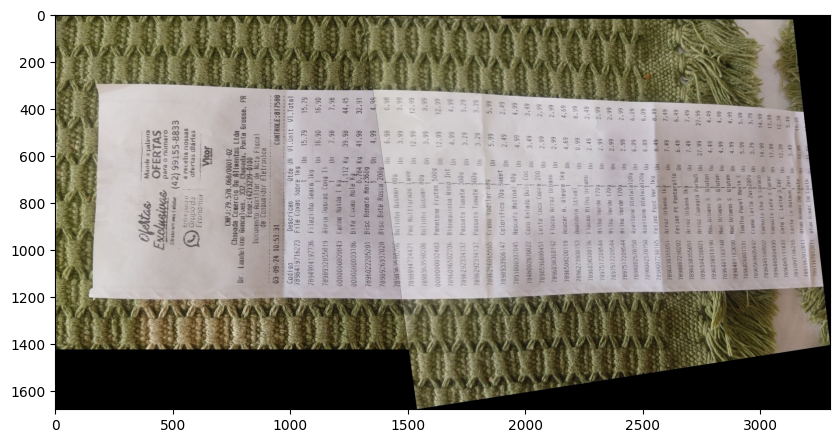

True

In [10]:
# Função para criar uma máscara gaussiana
def gaussian_mask(shape, sigma=500):
    """Cria uma máscara gaussiana bidimensional normalizada."""
    h, w = shape[:2]
    
    # Coordenadas centradas
    y, x = np.meshgrid(np.arange(h) - h // 2, np.arange(w) - w // 2, indexing='ij')
    
    mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return mask / mask.max()  # Normaliza para [0, 1]

def cola_imagens(base_image, mask_base, stitched_image, mask_sec):
    
    mask1 = mask_base
    mask2 = mask_sec
    
    # Expandir dimensões para corresponder aos 3 canais (RGB)
    mask1 = mask1[:, :, np.newaxis]
    mask2 = mask2[:, :, np.newaxis]
    
    # Ajustar as máscaras para que a soma seja igual a 1
    mask2 = (1-mask1 + mask2)/2 
    mask1 = 1 - mask2
    
    mask1 = np.where( mask_sec[:,:,np.newaxis] == 0, 1, mask1)
    mask2 = np.where(mask_base[:,:,np.newaxis] == 0, 1, mask2)
    
    resultado = (base_image * mask1 + stitched_image * mask2).astype(np.uint8)
    
    return resultado

def stitchImages(base_image, sec_image, homography, mask_base, mask_sec):

    global soma_imagens_coladas
    soma_imagens_coladas += 1
    
    # Finding size of new frame of stitched images and updating the homography matrix
    new_frame_size, correction, homographyMatrix = new_frame_size_and_matrix(homography, sec_image_shape=sec_image.shape[:2], base_image_shape=base_image.shape[:2])

    # Finally placing the images upon one another.
    stitched_image = cv.warpPerspective(sec_image, homographyMatrix, (new_frame_size[1], new_frame_size[0]))
    mask_sec = cv.warpPerspective(mask_sec, homographyMatrix, (new_frame_size[1], new_frame_size[0]))

    st_img_1 = stitched_image.copy() # cola primeira na segunda
    st_img_2 = stitched_image.copy() # cola segunda na primeira
    st_img_3 = stitched_image.copy() # cola primeira e segunda usando máscaras gaussianas

    st_img_2[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] = np.where(
    stitched_image[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] != 0, stitched_image[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]], base_image)

    st_img_1[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] = np.where( 
    base_image != 0, base_image, stitched_image[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] )

    nova_base = np.zeros(stitched_image.shape, dtype=np.uint8)
    nova_base[correction[1]:correction[1]+base_image.shape[0], correction[0]:correction[0]+base_image.shape[1]] = base_image
    # criar uma nova_base_mask
    nova_base_mask = np.zeros(nova_base.shape[:2], dtype=np.float64)
    nova_base_mask[correction[1]:correction[1]+mask_base.shape[0], correction[0]:correction[0]+mask_base.shape[1]] = mask_base
    st_img_3 = cola_imagens(nova_base, nova_base_mask, stitched_image, mask_sec)

    return st_img_2, stitched_image, mask_sec


result_file_name = "mosaico_0.jpg"
mosaico, _, _ = stitchImages(base_image=frames[idx_base], sec_image=frames[idx_sec], homography = H, mask_base=gaussian_mask(frames[idx_base].shape), mask_sec=gaussian_mask(frames[idx_sec].shape))
print("mosaico")
plot_image(mosaico)
cv.imwrite(result_file_name, mosaico)

# Cria um mosaico olhando para imagens visinhas
Considerando img1 e img2 como imagens "visinhas", o mosaico será construido modificando a img2 para colar na img1.
O resultado é devolvido com a composição das duas

5 9


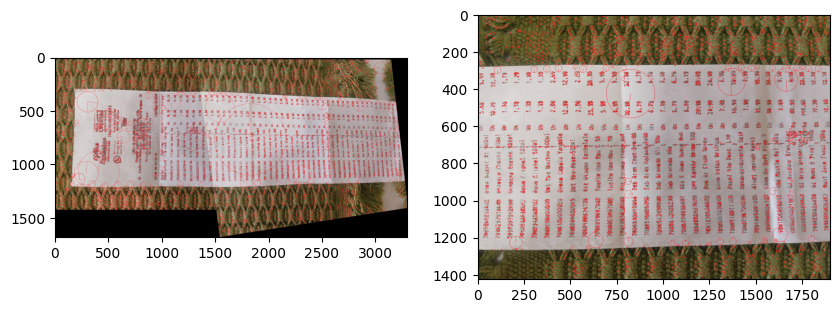

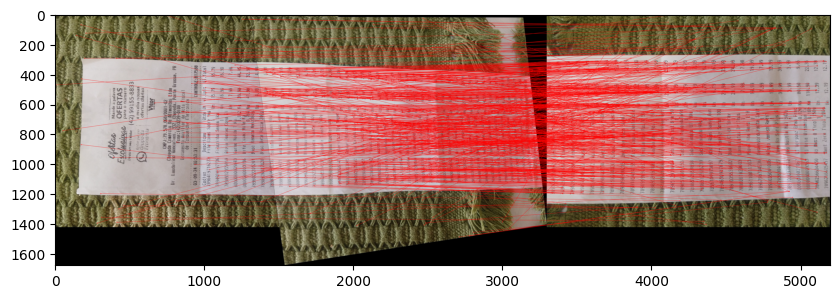

2 3


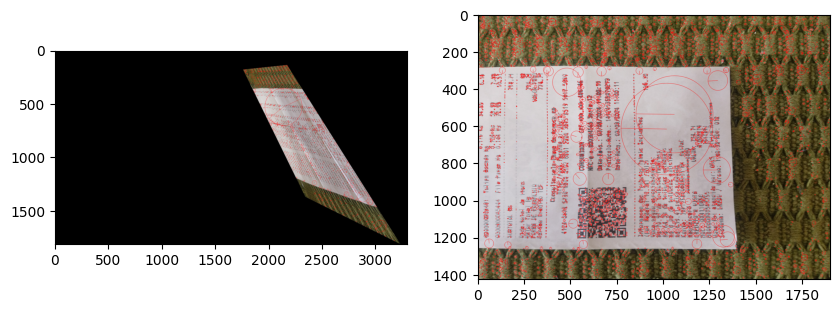

Not enough matches are found - 21/150
1 3
Voltei
1 3


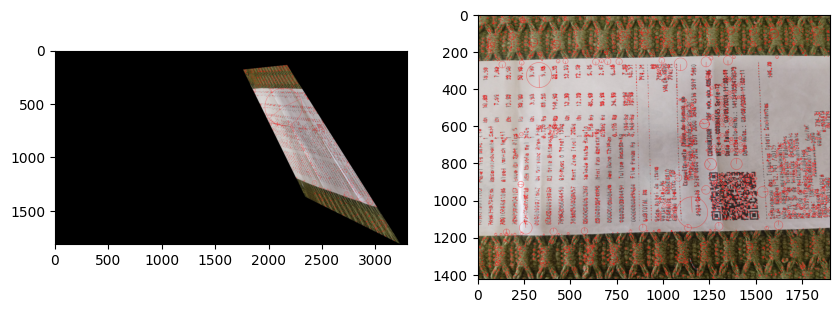

Not enough matches are found - 28/150
0 3
Voltei
0 3


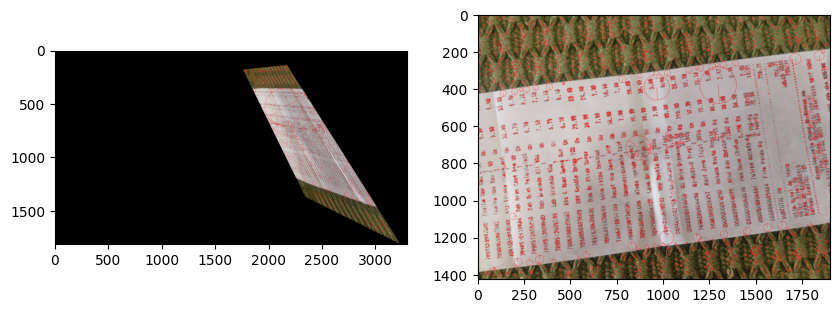

Not enough matches are found - 24/150
-1 3
3
Finalizando


In [11]:
# mosaico = frames[0]

# todo:
# ok 1. mater mosaico e frame de referência separados
# ok 2. img1 será o frame de referência
# ok 3. img2 será o próximo frame
# ok 4. iniciar a mask do próximo frame com uma mask gaussiana
# ok 5. o mosaico será atualizado com o resultado da função stitchImages
# ok 6. a função stitchImages precisa devolver o mosaico, o próximo frame rotacionado e a mask do próximo frame rotacioanda
# ok 7. o novo frame de referência será a stitched_image da função stitchImages e a nova mask precisa estar ajustada tal como stitched_image
# ok 8. a função stitchImages precisa receber o frame de referência, o próximo frame e as masks de cada um
# ok 9. a função stitchImages precisa rotacionar o próximo frame e sua mask para que fiquem na mesma orientação do frame de referência
# ok 10. depois de rotacionar, precisa atualizar o frame de referência e sua mask com o resultado da rotação
# 11. a colagem precisa ocorrer com base na stitched_image e não no frame de referência
# 12. a colagem precisa considerar as máscaras de cada frame na posição correta depois de rotacionadas
# ok 13. a função cola_imagens precisa ser ajustada para receber as máscaras de cada frame
# ok 14. a função cola_imagens precisa ajustar as masks temporariamente para que a soma dos pesos nas interescções seja 1
# ok 15. o ajuste pode ser: mask2 = (1-mask1 + mask2)/2 e mask1 = 1 - mask2

# [ x, x, Alvo, x , Pivo] Vamos tentar colar imagens distantes
img1 = mosaico #Pivo
mask_img1 = gaussian_mask(img1.shape)

alvo = ajustarAlvo(op, frames, idx_sec)


while(1):

    print(alvo, len(frames))
    if (alvo == -1): 
        print("Finalizando")
        break

    img2 = frames[alvo]

    matches, base_image_kp, sec_image_kp = find_matches(
        img1, img2, 0.75, debug_draw=True, min_matches=150
    )
    if(matches == None):

        alvo = reajustarAlvo(op, frames, alvo) #Volte uma imagem

        print(alvo, len(frames))

        if (alvo == -1):
            print(len(frames)) 
            print("Finalizando")
            break

        else:
            print("Voltei")
            continue #Volte ao início do loop   

    H = find_homography(base_image_kp, sec_image_kp, matches)
    mask_img2 = gaussian_mask(img2.shape)
    mosaico, img1, mask_img1 = stitchImages(base_image=mosaico, sec_image=img2, homography = H, mask_base=mask_img1, mask_sec=mask_img2)
    #plot_image(mosaico)
    cv.imwrite(result_file_name, mosaico)

    if op == 1 or op == 3:
        
        del frames[(alvo-1):]
        alvo = ajustarAlvo(op ,frames, alvo)    #Apagar o final do vetor não muda nenhuma posição.

    elif op == 2 or op == 4:

        del frames[:(alvo+1)]
        alvo = ajustarAlvo(op,frames,-1)    #Apagar o inicio do vetor muda a posição de todas as imagens. (Acho que pode encarecer o processo)

    if alvo == -1:  # Alvo == Pivo

        print("Finalizando")
        break

# Prints para Log

In [12]:
print(f"FINDMATCHINGSIFT:{soma_find_matching_sift}")
print(f"IMAGENSCOLADAS:{soma_imagens_coladas}")

FINDMATCHINGSIFT:8
IMAGENSCOLADAS:2
